In [8]:
# Import all Math tools:
#-----------------------
import numpy as np
from scipy import integrate
from scipy.spatial.distance import directed_hausdorff
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline
plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy
# Figure dpi
dpi = 72

import timeit

import sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

### Function Defintions

In [3]:
def time_series_dist(x0,N):
    n = range(0,N)
    xn = []
    for i in n:
        xn.append(x0)
        x0 = f(x0)
    return np.array(xn)

def declump(X,N,iterations):
    X = np.sort(X.transpose()[0])
    dst_btwn_cnsc_pnts = [np.abs(X[i]-X[i-1]) for i in range(1,len(X))]
    smllst_dst_index = np.argmin(dst_btwn_cnsc_pnts)
    X = np.delete(X,smllst_dst_index) # delete the left sample point
    
    for i in range(0,iterations-1):
        if smllst_dst_index > 1:
            dst_btwn_cnsc_pnts =  dst_btwn_cnsc_pnts[0:smllst_dst_index-1] + [np.abs(X[smllst_dst_index]-X[smllst_dst_index-1])] + dst_btwn_cnsc_pnts[smllst_dst_index+1 : len(X)]
        elif smllst_dst_index == 1:
            dst_btwn_cnsc_pnts = [np.abs(X[smllst_dst_index]-X[smllst_dst_index-1])] + dst_btwn_cnsc_pnts[smllst_dst_index+1 : len(X)]
        else:
            dst_btwn_cnsc_pnts = dst_btwn_cnsc_pnts[smllst_dst_index+1 : len(X)]

        smllst_dst_index = np.argmin(dst_btwn_cnsc_pnts)
        X = np.delete(X,smllst_dst_index) # delete the left sample point
        
    X = X[:,None]
    N = N - iterations
    return X, N;

def Get_GP_Orbit_Points(x0,nmax,m):
    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        Xstar = np.linspace(px[n-1][0],px[n-1][0], 1).reshape(-1, 1)
        Ystar, Vstar = m.predict(Xstar)
        Ystar = np.append(Ystar[0],Ystar[0])
        py[n] = Ystar #f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]
    return px, py;

def Get_f_Orbit_Points(x0,nmax,f):
    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        py[n] = f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]
    return px, py;

def Hausdorff(x0,nmax,m,f,transience_thresh):
    GP_X = Get_GP_Orbit_Points(x0,nmax+transience_thresh,m)[0].transpose()[0]
    f_X = Get_f_Orbit_Points(x0,nmax+transience_thresh,f)[0].transpose()[0]
    GP_Y = Get_GP_Orbit_Points(x0,nmax+transience_thresh,m)[1].transpose()[0]
    f_Y = Get_f_Orbit_Points(x0,nmax+transience_thresh,f)[1].transpose()[0]
    u = np.empty(2*(nmax)+1, dtype=object)
    v = np.empty(2*(nmax)+1, dtype=object)
    for i in range(transience_thresh,2*(nmax)+1+transience_thresh):
        u[i-transience_thresh] = (GP_X[i],GP_Y[i])
        v[i-transience_thresh] = (f_X[i],f_Y[i])
    u = u.tolist()
    v = v.tolist()
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

### Experiment 1 b) Linearly spaced sample point distribution
Relationship between $r$ and $H$ with varying $N$ and $x_0$. 

Setup Parameters

In [4]:
Nmax = 15 # max number of sample points
Nmin = 3
#--------------------
r1 = np.linspace(0.01, 3, 75)
r2 = np.linspace(3.01, 3.43, 100)
r3 = np.linspace(3.431, 3.45, 100)
r4 = np.linspace(3.451, 3.54, 50)
r5 = np.linspace(3.541, 3.56, 50)
r6 = np.linspace(3.561, 3.565, 50)
r7 = np.linspace(3.5651,3.5699, 200)
r8 = np.linspace(3.56991,3.5699461, 100)
r9 = np.linspace(3.569947,4, 200)
r_range = np.concatenate((r1,r2,r3,r4,r5,r6,r7,r8,r9)) # range of r values
print(len(r_range))
#r_range = np.linspace(0.01,4,3)
#-------------------
# choose one:
x0_N = 20
x0_range = np.linspace(1/x0_N,1-1/x0_N,x0_N)
#x0_range = np.linspace(0.01,0.99,3)
#x0_i = 0.2 # initial orbit position for cobweb
#------------------
# for time series dist only -> choose one:
#x0_time_dist_range = np.linspace(0.01,0.99,20)
#x0_time_dist_i = 0.4 # time series dist x0 starting value
#------------------
nmax = 100 # max iterations of orbit for Hausdorff dist. calculation

#======================================

Xnew = np.linspace(-0.05, 1.05, 100)[:, None]
result = []
N_Array = []
R = []
H = []
# -- Approximate Calculation Time: --
start_time = timeit.default_timer()
#->
k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
f = lambda x: 4*x*(1-x)
X = np.linspace(0, 1, Nmax)[:,None]
#X = np.random.uniform(0,1, Nmax)[:,None]
#X = time_series_dist(0.4,Nmax)[:,None] #time_series_dist(x0,N)
#X,N = declump(X,Nmax,2);
sd = 0
ep = np.random.normal(0., sd, (Nmax,1))
Y = f(X) + ep
m = GPy.models.GPRegression(X, Y, k)
m.constrain_positive(warning=False)
m.Gaussian_noise.variance = sd**2
m.Gaussian_noise.variance.fix()
m.optimize()
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
#--------
h = Hausdorff(0.2,nmax,m,f)
#--------
R.append(4)
H.append(h)
X0_Array = [R,H]
N_Array.append(X0_Array)
result.append(N_Array)
#->
elapsed = timeit.default_timer() - start_time
multiplier = (Nmax-Nmin) * len(x0_range) * len(r_range)
print(str(multiplier) + " x " + str(elapsed) + " seconds.")
elapsed = elapsed * multiplier
print("Approximate calculation time needed: " + str(elapsed) + " seconds = " + str(elapsed/60) + " minutes = " + str(elapsed/3600) + " hours.")
print("Approximate calculation time needed: " + str(np.floor(elapsed/3600)) + " hrs, " + str(np.floor((elapsed/3600-np.floor(elapsed/3600))*60)) + " min, " + str(((elapsed/3600-np.floor(elapsed/3600))*60 - np.floor((elapsed/3600-np.floor(elapsed/3600))*60))*60) + " sec.")

925


TypeError: Hausdorff() missing 1 required positional argument: 'transience_thresh'

Experiment:

In [ ]:
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

result = []
for n_i in range(Nmin,Nmax + 1):
    N_Array = []
    for x0_i in x0_range:
        R = []
        H = []
        for r_i in r_range:
            k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
            # -- Recalculate GP fit: -- 
            f = lambda x: r_i*x*(1-x)
            X = np.linspace(0, 1, n_i)[:,None]
            #X,N = declump(X,n_i,2);
            sd = 0
            ep = np.random.normal(0., sd, (n_i,1))
            Y = f(X) + ep
            m = GPy.models.GPRegression(X, Y, k)
            m.constrain_positive(warning=False)
            m.Gaussian_noise.variance = sd**2
            m.Gaussian_noise.variance.fix()
            m.optimize()
            mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
            #--------
            h = Hausdorff(x0_i,nmax,m,f)
            #--------
            R.append(r_i)
            H.append(h)
        X0_Array = [R,H]
        N_Array.append(X0_Array)
    result.append(N_Array)

Results:

Plot 1

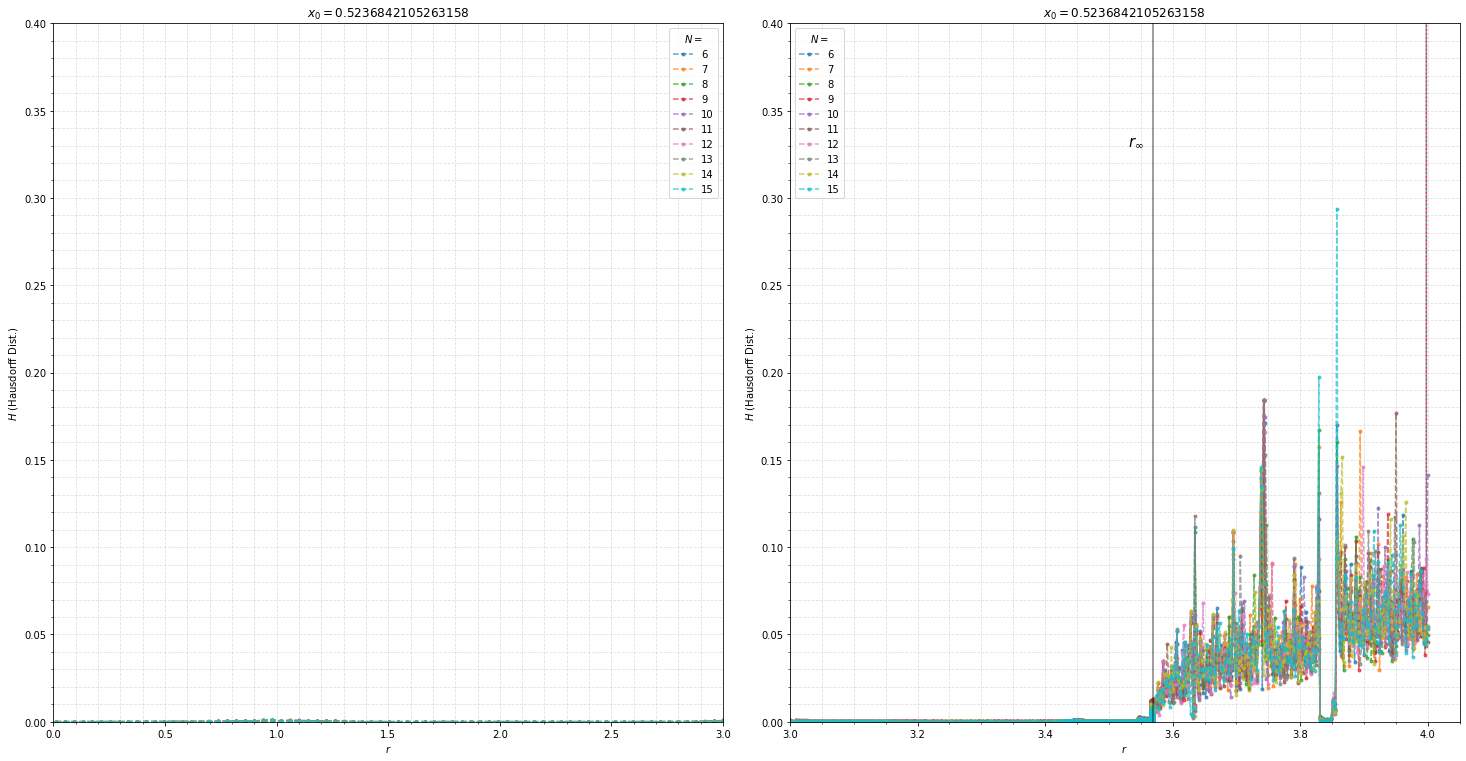

In [35]:
# Change plot
x0_range_i = 10 # range: 0-19
Nmax = 15 # max number of sample points for this data set = 10
Nmin = 6 # Max value = Nmax
upperbound = 0.4

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax+1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=upperbound);
ax.set_xlim(left=0,right=3);

#---
#Second Plot:
#fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(122)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=upperbound);
ax.set_xlim(left=3, right=4.05);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.53,0.33,r"$r_\infty$", fontsize=15)

plt.subplots_adjust(wspace=0.1)

Plot 2

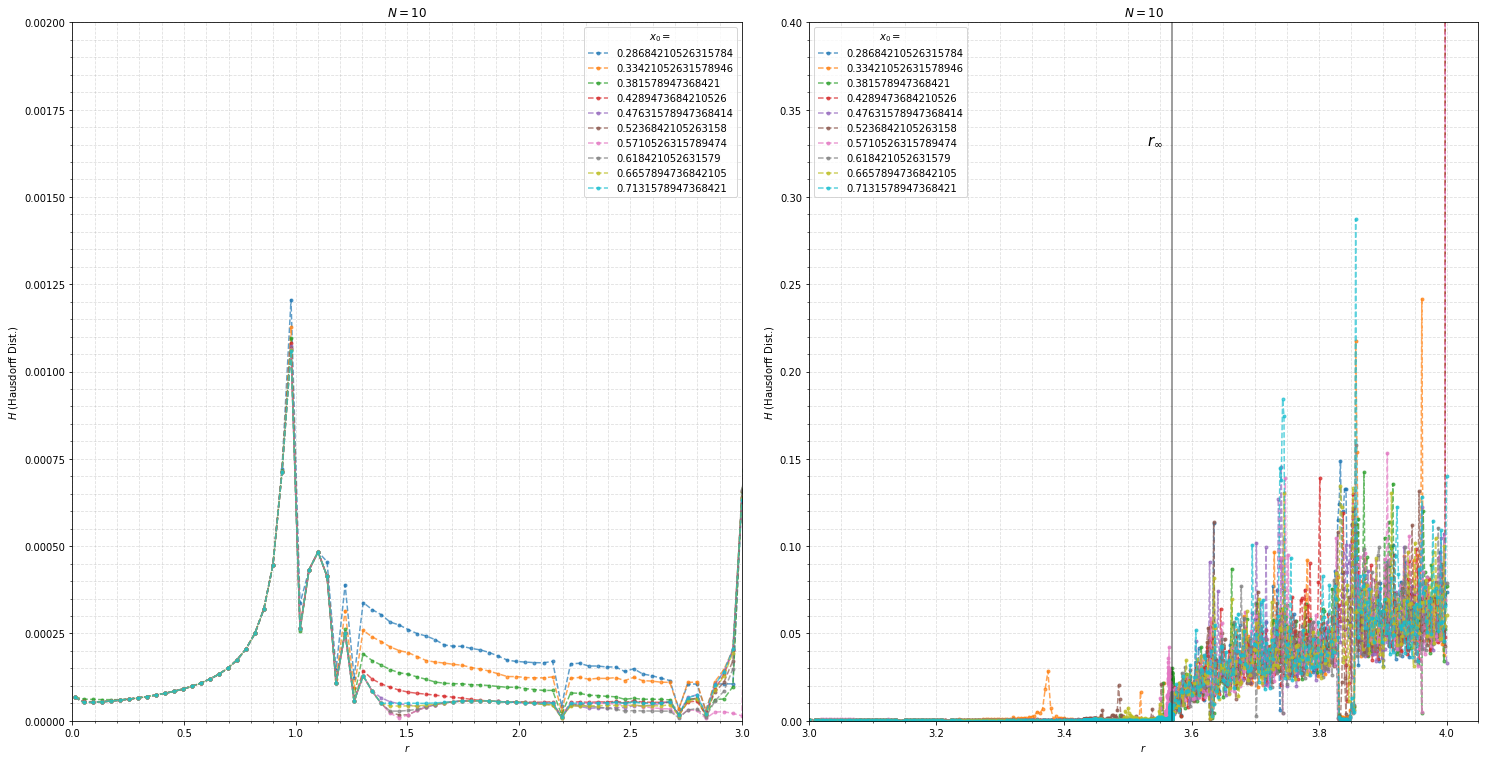

In [37]:
# Change plot
Nmax = 10 # max number of sample points for this data set = 10
Nmin = Nmax # Max value = Nmax
start = 5
end = len(x0_range) - start
upperbound = 0.4

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 3][x0_range_i][0],result[Nmax - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=x0_range[start:end],title="$x_0=$");
ax.set_ylim(bottom=0,top=0.002);
ax.set_xlim(left=0,right=3);

#---
#Second Plot:
#fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(122)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 3][x0_range_i][0],result[Nmax - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=x0_range[start:end],title="$x_0=$");
ax.set_ylim(bottom=0,top=upperbound);
ax.set_xlim(left=3, right=4.05);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.53,0.33,r"$r_\infty$", fontsize=15)

plt.subplots_adjust(wspace=0.1)

### Experiment 1 b-2) Linearly spaced sample point distribution
Relationship between $r$ and $H$ with varying $N$ and $x_0$.

Setup

In [5]:
Nmax = 10 # max number of sample points
Nmin = 3
#--------------------
r1 = np.linspace(0.01, 3, 75)
r2 = np.linspace(3.01, 3.43, 100)
r3 = np.linspace(3.431, 3.45, 100)
r4 = np.linspace(3.451, 3.54, 50)
r5 = np.linspace(3.541, 3.56, 50)
r6 = np.linspace(3.561, 3.565, 50)
r7 = np.linspace(3.5651,3.5699, 150)
r8 = np.linspace(3.56991,3.5699461, 50)
r9 = np.linspace(3.569947,4, 200)
r_range = np.concatenate((r1,r2,r3,r4,r5,r6,r7,r8,r9)) # range of r values
print(len(r_range))
#r_range = np.linspace(0.01,4,3)
#-------------------
# choose one:
x0_N = 16
x0_range = np.linspace(1/x0_N,1-1/x0_N,x0_N-1)
#x0_range = np.linspace(0.01,0.99,3)
#x0_i = 0.2 # initial orbit position for cobweb
#------------------
# for time series dist only -> choose one:
#x0_time_dist_range = np.linspace(0.01,0.99,20)
#x0_time_dist_i = 0.4 # time series dist x0 starting value
#------------------
nmax = 100 # max iterations of orbit for Hausdorff dist. calculation

#============================================

Xnew = np.linspace(-0.05, 1.05, 100)[:, None]
result = []
N_Array = []
R = []
H = []
# -- Approximate Calculation Time: --
start_time = timeit.default_timer()
#->
k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
f = lambda x: 4*x*(1-x)
X = np.linspace(0, 1, Nmax)[:,None]
#X = np.random.uniform(0,1, Nmax)[:,None]
#X = time_series_dist(0.4,Nmax)[:,None] #time_series_dist(x0,N)
#X,N = declump(X,Nmax,2);
sd = 0
ep = np.random.normal(0., sd, (Nmax,1))
Y = f(X) + ep
m = GPy.models.GPRegression(X, Y, k)
m.constrain_positive(warning=False)
m.Gaussian_noise.variance = sd**2
m.Gaussian_noise.variance.fix()
m.optimize()
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
#--------
h = Hausdorff(0.2,nmax,m,f,500)
#--------
R.append(4)
H.append(h)
X0_Array = [R,H]
N_Array.append(X0_Array)
result.append(N_Array)
#->
elapsed = timeit.default_timer() - start_time
multiplier = (Nmax-Nmin) * len(x0_range) * len(r_range)
print(str(multiplier) + " x " + str(elapsed) + " seconds.")
elapsed = elapsed * multiplier
print("Approximate calculation time needed: " + str(elapsed) + " seconds = " + str(elapsed/60) + " minutes = " + str(elapsed/3600) + " hours.")
print("Approximate calculation time needed: " + str(np.floor(elapsed/3600)) + " hrs, " + str(np.floor((elapsed/3600-np.floor(elapsed/3600))*60)) + " min, " + str(((elapsed/3600-np.floor(elapsed/3600))*60 - np.floor((elapsed/3600-np.floor(elapsed/3600))*60))*60) + " sec.")

825
86625 x 0.5178912999999739 seconds.
Approximate calculation time needed: 44862.33386249773 seconds = 747.7055643749623 minutes = 12.46175940624937 hours.
Approximate calculation time needed: 12.0 hrs, 27.0 min, 42.333862497735026 sec.


Experiment

In [ ]:
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

result = []
for n_i in range(Nmin,Nmax + 1):
    X = np.linspace(0, 1, n_i)[:,None]
    N_Array = []
    for x0_i in x0_range:
        R = []
        H = []
        for r_i in r_range:
            k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
            # -- Recalculate GP fit: -- 
            f = lambda x: r_i*x*(1-x)
            #X,N = declump(X,n_i,2);
            sd = 0
            ep = np.random.normal(0., sd, (n_i,1))
            Y = f(X) + ep
            m = GPy.models.GPRegression(X, Y, k)
            m.constrain_positive(warning=False)
            m.Gaussian_noise.variance = sd**2
            m.Gaussian_noise.variance.fix()
            m.optimize()
            mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
            #--------
            h = Hausdorff(x0_i,nmax,m,f,1000)
            #--------
            R.append(r_i)
            H.append(h)
        X0_Array = [R,H]
        N_Array.append(X0_Array)
    result.append(N_Array)

Results

In [9]:
result = np.load('Experiment1b.npy')

Plot 1

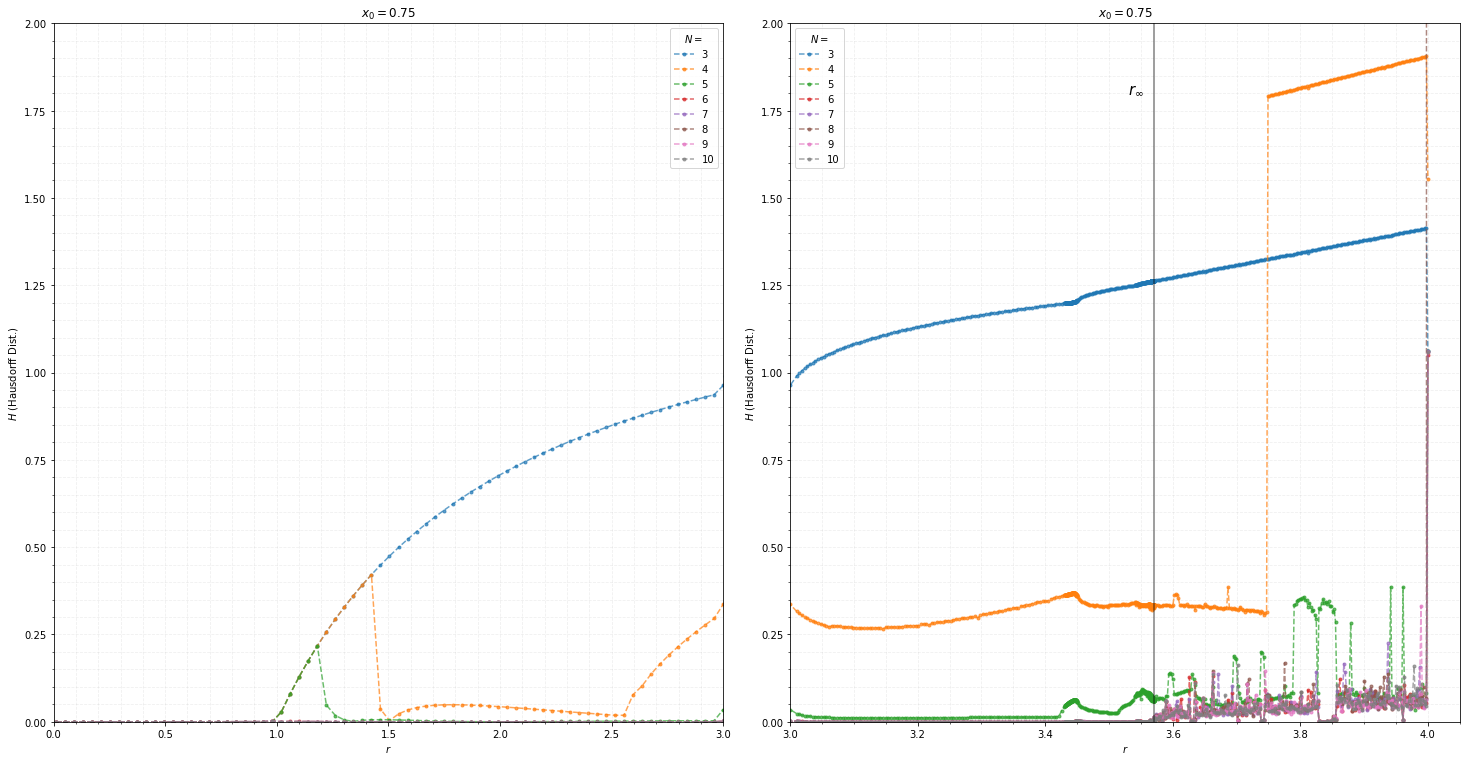

In [28]:
# Change plot
x0_range_i = 11 # range: 0-15
Nmax = 10 # max number of sample points for this data set = 10
Nmin = 3 # Max value = Nmax
upperbound = 2

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax+1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.2, ls='--')
ax.grid(which='major', alpha=0.2, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=upperbound);
ax.set_xlim(left=0,right=3);

#---
#Second Plot:
#fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(122)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.2, ls='--')
ax.grid(which='major', alpha=0.2, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=upperbound);
ax.set_xlim(left=3, right=4.05);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.53,upperbound-upperbound/10,r"$r_\infty$", fontsize=15)

plt.subplots_adjust(wspace=0.1)

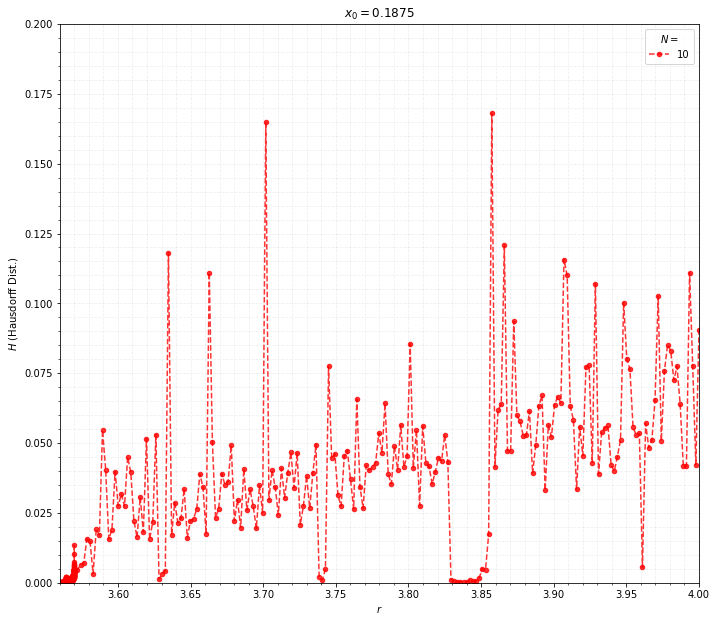

In [60]:
# Change plot
x0_range_i = 2 # range: 0-15
Nmax = 10 # max number of sample points for this data set = 10
Nmin = 10 # Max value = Nmax
upperbound = 0.2

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.2*dpi),dpi=dpi)
ax = fig.add_subplot(121)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.8, lw=1.5, markersize=9,c='r')

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.2, ls='--')
ax.grid(which='major', alpha=0.2, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=upperbound);
ax.set_xlim(left=3.56, right=4);

#Bifurcation points:
# ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
# ax.text(3.53-0.005,upperbound-upperbound/10,r"$r_\infty$", fontsize=15)

Plot 2

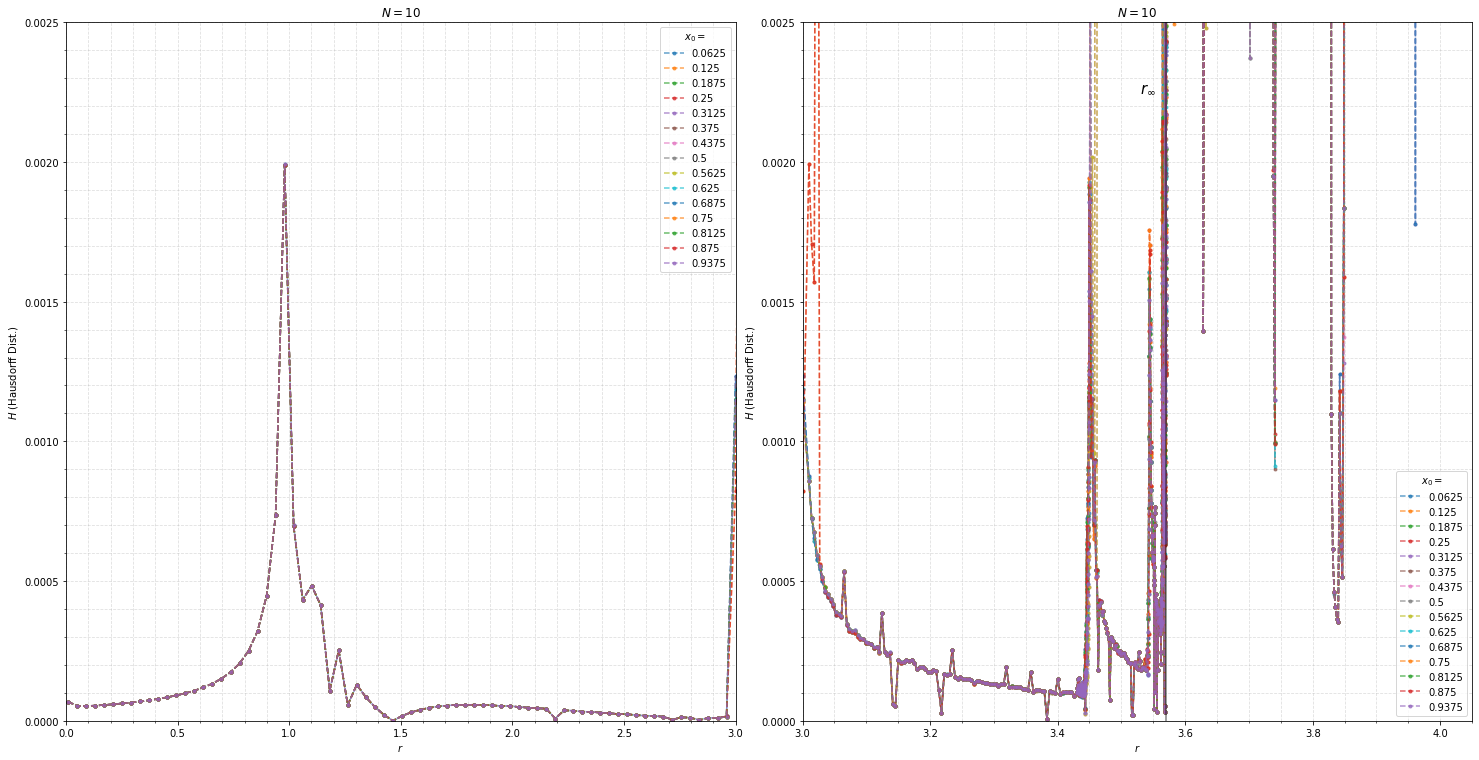

In [65]:
# Change plot
Nmax = 10 # max number of sample points for this data set = 10
Nmin = Nmax # Max value = Nmax
start = 0
end = len(x0_range) - start
upperbound = 0.0025

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 3][x0_range_i][0],result[Nmax - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=x0_range[start:end],title="$x_0=$");
ax.set_ylim(bottom=0,top=upperbound);
ax.set_xlim(left=0,right=3);

#---
#Second Plot:
#fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(122)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 3][x0_range_i][0],result[Nmax - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=x0_range[start:end],title="$x_0=$");
ax.set_ylim(bottom=0,top=upperbound);
ax.set_xlim(left=3, right=4.05);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.53,upperbound-upperbound/10,r"$r_\infty$", fontsize=15)

plt.subplots_adjust(wspace=0.1)

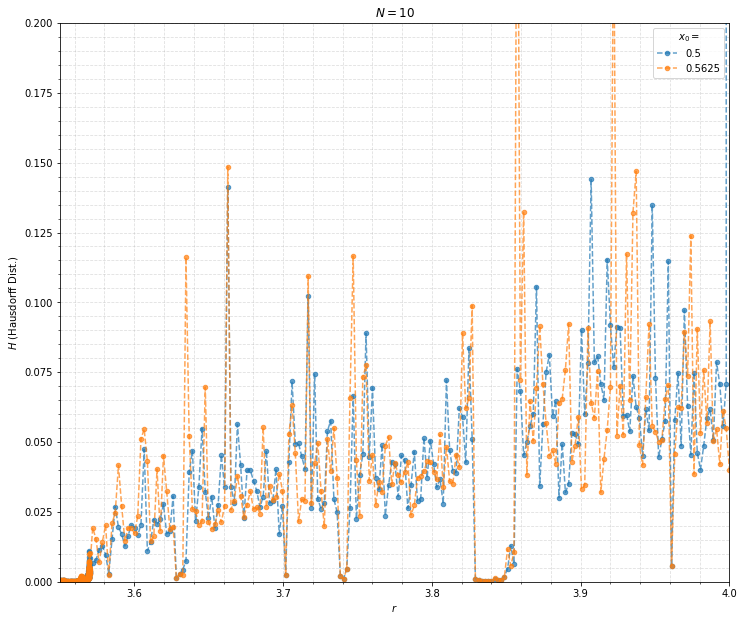

In [78]:
# Change plot
Nmax = 10 # max number of sample points for this data set = 10
Nmin = Nmax # Max value = Nmax
start = 7
end = 9
upperbound = 0.2

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.2*dpi),dpi=dpi)
ax = fig.add_subplot(121)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 3][x0_range_i][0],result[Nmax - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5, markersize=9)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=x0_range[start:end],title="$x_0=$");
ax.set_ylim(bottom=0,top=upperbound);
ax.set_xlim(left=3.55, right=4);

#Bifurcation points:
# ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
# ax.text(3.53,upperbound-upperbound/10,r"$r_\infty$", fontsize=15)

plt.subplots_adjust(wspace=0.1)